# ***Google Captcha image recognition***
**A Deep Learning Project using TensorFlow**

*by Emma Begard, Augustin Bouveau, Gabin Jobert--Rollin, Hugues Boisdon*

## I Data **Fetching**

Our source Dataset can be found at : *https://www.kaggle.com/datasets/mikhailma/test-dataset*

***credits : Mike Mazurov***

### I.1 **Dowloading** Dataset Files from ***KaggleHub*** Source

In [1]:
import kagglehub

DATA_FOLDER_PATH_IF_CACHED = kagglehub.dataset_download("mikhailma/test-dataset")
print("Path to dataset files in cache:", DATA_FOLDER_PATH_IF_CACHED)

/home/ehrone/5A/IA/TP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files in cache: /home/ehrone/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1


The data files are downloaded in the Users **cache** by default.
If the data source folder is moved, ***please update*** the following *path variable*

In [2]:
DATA_FOLDER_PATH_IF_MOVED = "" # Data folder path if data was moved since download

In [3]:
def getDataSourceFolderPath() -> str:
    return DATA_FOLDER_PATH_IF_CACHED if DATA_FOLDER_PATH_IF_MOVED == "" else DATA_FOLDER_PATH_IF_MOVED

def getImagesDataFolderPath() -> str:
    return getDataSourceFolderPath() +"/Google_Recaptcha_V2_Images_Dataset/images"

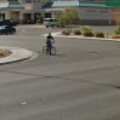

In [4]:
from PIL import Image
path = DATA_FOLDER_PATH_IF_CACHED if DATA_FOLDER_PATH_IF_MOVED == "" else DATA_FOLDER_PATH_IF_MOVED
Image.open(getImagesDataFolderPath() +"/Bicycle/Bicycle (1).png")

### I.2 First Try at **Loading** the Training and Validation Datasets

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_DIMENSIONS = (120, 120) # pixels per pixels
SEED_RANDOM = 123

VALIDATION_RATIO = 0.2

def getDatasets(batch_size=BATCH_SIZE, 
                img_dims=IMG_DIMENSIONS, 
                validation_ratio=VALIDATION_RATIO, 
                seed=SEED_RANDOM) -> tuple:
  train = image_dataset_from_directory(
    getImagesDataFolderPath(),
    validation_split= validation_ratio,
    subset= "training",
    
    seed=       seed,
    image_size= img_dims,
    batch_size= batch_size)

  validation = image_dataset_from_directory(
    getImagesDataFolderPath(),
    validation_split= validation_ratio,
    subset= "validation",
    
    seed=       seed,
    image_size= img_dims,
    batch_size= batch_size)
  
  return train, validation


2024-12-09 14:45:08.851820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733751908.935312    1099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733751908.961293    1099 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 14:45:09.174893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The **keras** sublibrary of ***TensorFlow*** allow us to directly load our datasets (and ensure the size normalization of 120px per 120px for all images).

In [7]:
train_dataset, validation_dataset = getDatasets()

CLASS_NAMES = train_dataset.class_names
print(CLASS_NAMES)

Found 13500 files belonging to 9 classes.
Using 10800 files for training.


I0000 00:00:1733751921.224647    1099 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 13500 files belonging to 9 classes.
Using 2700 files for validation.
['Bicycle', 'Bridge', 'Bus', 'Car', 'Crosswalk', 'Hydrant', 'Other', 'Palm', 'Traffic Light']


Our model is going to be guessing between these classes for each image.

#### Data Sample for Visualization  

2024-12-09 14:45:26.275123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


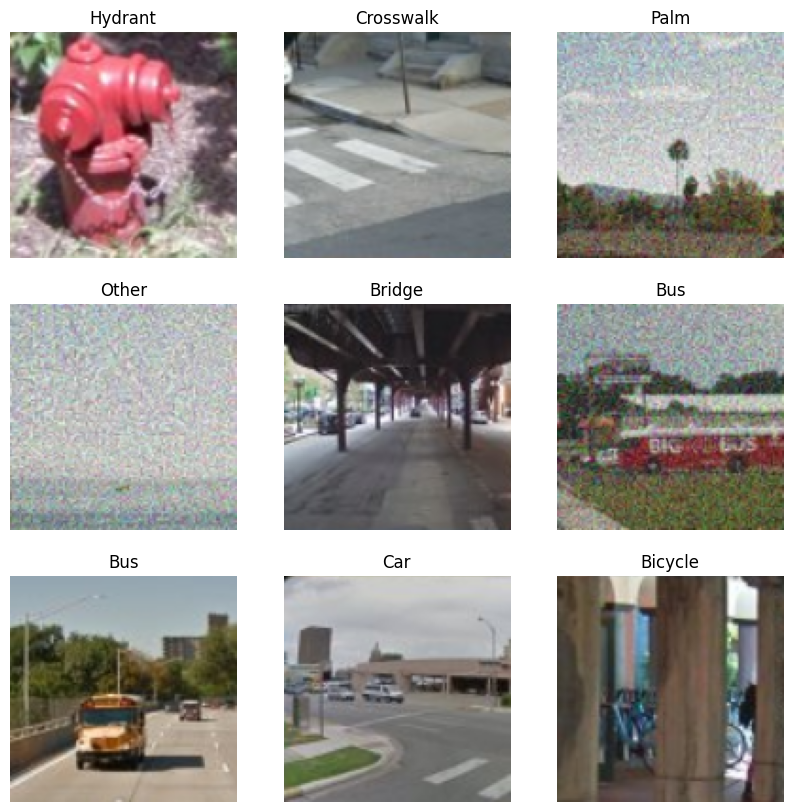

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

## II Data **Preprocessing**

### 1 Preprocessing layers & Optimizations

#### 1.1 **Normalization Layer** for pixel values

In [9]:
from tensorflow.keras.layers import Rescaling

def getNormalizationLayer():
    return Rescaling(1./255)

Pixel values will now be bound from 0 to 1 instead of 0 to 255.

#### 1.2 Data Augmentation Layers

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

def getAugmentationLayers(maxRotation:float= 0.1, maxZoom:float= 0.1) -> Sequential:
    return Sequential(
    [
        RandomFlip("horizontal",
                        input_shape=(IMG_DIMENSIONS[0],
                                    IMG_DIMENSIONS[1],
                                    3)),
        RandomRotation(maxRotation),
        RandomZoom(maxZoom),
    ]
    )

/home/ehrone/5A/IA/TP/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-09 14:45:35.291675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


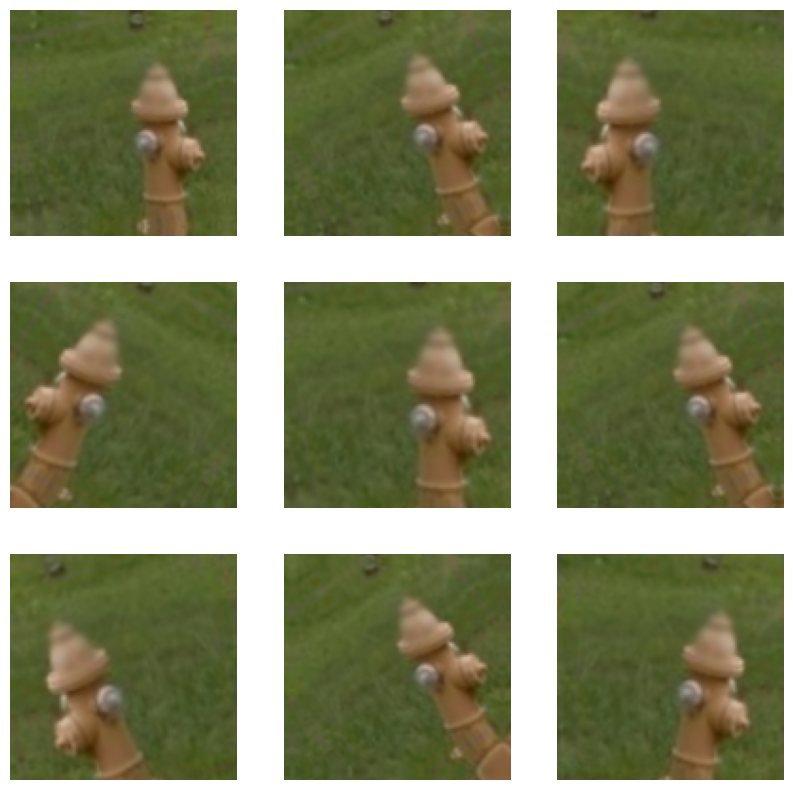

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = getAugmentationLayers()(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### 1.3 **Optimizations** of Data memory caching, availibity and randomization

In [ ]:
from tensorflow.data import AUTOTUNE

train_dataset_opti        = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset_opti   = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### 2 Organizing & Rebalancing the datasets

#### 2.1 Creating sub folders for test, train and validation for the original dataset

At first, whithout balancing the number of images per class, our model was unable to predict some classes at all, as had a lot less images than other. To counter this effect we duplicated images from the weaker classes to balance everything. However, when setting the datasets, we might have had duplicated images in both training and validation, hence we needed to separate the original dataset into three folders (training, validation, test), to be sure teh model did not validate on already seen images. 
Then to still balance our classes, we apply the balancing function to the training dataset, and validation too, to have enought images for the validation setp.

In [12]:
import os
import random
import shutil

def split_dataset_by_class(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2, test_size=0.1, min_images=10):
    # Ensure the directories for train, validation, and test exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Traverse each subdirectory (class folder) in the source directory
    for class_name in os.listdir(source_dir):
        class_folder = os.path.join(source_dir, class_name)
        
        # Skip non-directories (just in case there are files in the source dir)
        if not os.path.isdir(class_folder):
            continue

        # Get all image files in the class folder
        image_files = [os.path.join(class_folder, file) for file in os.listdir(class_folder)
                       if file.lower().endswith(('png', 'jpg', 'jpeg'))]  # Adjust for your image file extensions

        # Skip the class if there are fewer than min_images
        if len(image_files) < min_images:
            print(f"Skipping class {class_name} because it has fewer than {min_images} images.")
            continue

        # Create the same class subdirectories in train, val, and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Shuffle the image files for randomness
        random.shuffle(image_files)

        # Calculate the number of images for each set
        total_images = len(image_files)
        train_count = int(total_images * train_size)
        val_count = int(total_images * val_size)
        test_count = total_images - train_count - val_count  # Remaining for test

        # Split the images
        train_images = image_files[:train_count]
        val_images = image_files[train_count:train_count + val_count]
        test_images = image_files[train_count + val_count:]

        # Copy the images into the corresponding directories
        def copy_images(image_list, target_dir):
            for img_path in image_list:
                shutil.copy(img_path, target_dir)

        copy_images(train_images, os.path.join(train_dir, class_name))
        copy_images(val_images, os.path.join(val_dir, class_name))
        copy_images(test_images, os.path.join(test_dir, class_name))

        print(f"Class {class_name}: {train_count} for training, {val_count} for validation, {test_count} for testing.")

#### 2.2 Balancing classes in the training folder and validation folder

In [13]:
import os
import random
from PIL import Image

def duplicate_images_randomly_per_folder(root_dir, target_count_per_folder, min_img=5, max_img=100):
    # Traverse all subdirectories in the root directory
    for root, subdirs, files in os.walk(root_dir):
        # Skip the root directory itself
        if root == root_dir:  
            continue

        # Print the current directory being processed (for debugging)
        print(f"Processing folder: {root}")
        
        # Filter image files (png, jpg, jpeg)
        image_files = [os.path.join(root, file) for file in files if file.lower().endswith(('png', 'jpg', 'jpeg'))]
        current_count = len(image_files)
        
        # If the number of images is less than min_img, delete the folder
        if current_count < min_img:
            print(f"Directory {root} has fewer than {min_img} images, deleting folder.")
            # Delete all the files in the folder before removing it
            for file in image_files:
                os.remove(file)
            os.rmdir(root)  # Remove the folder itself
            continue  # Skip to the next folder
        
        # If the number of images exceeds max_img, randomly delete images to meet max_img limit
        if current_count > max_img:
            print(f"Directory {root} has more than {max_img} images, deleting excess images.")
            images_to_delete = current_count - max_img
            random.shuffle(image_files)  # Shuffle to delete images randomly
            for img_path in image_files[:images_to_delete]:
                os.remove(img_path)  # Remove the selected images
            current_count = max_img  # Update current count after deletion
        
        # If the current count is already greater than or equal to the target, skip duplication
        if current_count >= target_count_per_folder:
            print(f"Directory {root} already has {current_count} images, no duplication needed.")
            continue
        
        # Calculate how many more images are needed
        images_needed = target_count_per_folder - current_count
        print(f"Duplicating {images_needed} images randomly in {root}.")
        
        # Duplicate images randomly until the target count is reached
        while images_needed > 0:
            random.shuffle(image_files)  # Shuffle the list of image files
            for img_path in image_files:
                if images_needed <= 0:
                    break
                
                # Load the image
                img = Image.open(img_path)
                
                # Create a unique name for the duplicated image
                folder_name, img_name = os.path.split(img_path)
                duplicated_img_name = f"{os.path.splitext(img_name)[0]}_dup{images_needed}{os.path.splitext(img_name)[1]}"
                duplicated_img_path = os.path.join(folder_name, duplicated_img_name)
                
                # Save the duplicated image with a new name
                img.save(duplicated_img_path)

                # Decrement the remaining number of images needed
                images_needed -= 1

        print(f"Duplicated images in {root} to reach {target_count_per_folder} images.")

### 3 Image preprocesssing for Resnet

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

def preprocess_data_for_resnet(image, label):
    image = preprocess_input(image)  # Apply preprocessing
    return image, label

## III Our differents approaches

### 1 Naive CNN models

#### III.1.A Defining and compiling the model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

first_model = Sequential([
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "First_Model")

The first model had **10** layers (**3** *Conv2D* and **3** *MaxPooling2D*, **1** *Flatten* and **2** *Dense*). After training, we saw a **validation accuracy** of 0.4224 and a **validation loss** of 4.0163, with an **accuracy** of 0.9 in training. Our model is clearly overfitted and is unable to identify the classes.

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

first_model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

first_model.summary()

#### III.1.B Training the model

In [ ]:
EPOCHS_FIRST= 10

first_history = first_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS_FIRST
)

#### III.1.C Visualizing results

In [ ]:
acc = first_history.history['accuracy']
val_acc = first_history.history['val_accuracy']

loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs_range = range(EPOCHS_FIRST)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # Convert the labels from tensor to numpy

# Step 2: Get predictions from the model (do this once, not twice)
predictions = first_model.predict(validation_dataset)

# Convert predictions to class labels (assuming probabilities)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Generate the classification report
infos_2 = classification_report(y_true, predicted_labels)
print(infos_2)

#### III.2.A Defining and compiling the model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "Second_Model")

We decided to add 3 layer at the top for data **augmentation** (1 *RandomFlip*, 1 *RandomRotation*, 1 *RandomZoom*) and 1 *Rescaling* Layer for **normalization** (from 0->255 to 0->1). We saw a change in **validation accuracy** to 0.6226 and **loss** to 1.0823, with a minimal difference with training (< 0.04). We fixed the overfitting issue and greatly improved the loss. Next, we added 1 *Dropout* Layer before the *Flatten* Layer. The hope was to futher lessen the overfitting. We can see that the f1-Score was improved but the effect is slight.

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

second_model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

second_model.summary()

#### III.2.B Training the model

In [ ]:
EPOCHS_SECOND = 15
second_history = second_model.fit(
  train_dataset,
  validation_data= validation_dataset,
  epochs=EPOCHS_SECOND
)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # Convert the labels from tensor to numpy

# Step 2: Get predictions from the model (do this once, not twice)
predictions = second_model.predict(validation_dataset)

# Convert predictions to class labels (assuming probabilities)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Generate the classification report
infos_2 = classification_report(y_true, predicted_labels)
print(infos_2)

#### III.2.C Visualizing results

In [ ]:
acc = second_history.history['accuracy']
val_acc = second_history.history['val_accuracy']

loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs_range = range(EPOCHS_SECOND)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.image import decode_jpeg, resize
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_data_for_resnet(image, label):
    image = preprocess_input(image)  # Apply preprocessing
    return image, label
train_dataset, validation_dataset = getDatasets()

train_dataset= train_dataset.map(preprocess_data_for_resnet).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.map(preprocess_data_for_resnet).cache().prefetch(buffer_size=AUTOTUNE)

### 2 Testing CNN models with new preprocessings

#### 1 partie emma
In this part we test convolutional layers models.

In [24]:
source_directory = getImagesDataFolderPath()
train_directory = './datas/train'  
val_directory = './datas/validation' 
test_directory = './datas/test' 

# Split the dataset, skipping classes with fewer than 500 images
split_dataset_by_class(source_directory, train_directory, val_directory, test_directory, min_images=500)

# Define your target number of images for each subfolder
target_number_per_folder = 1500  # Set your target number of images per folder

# Set your root image directory (which contains subfolders like 'cars', 'bicycles', etc.)
root_image_directory = getImagesDataFolderPath() 

# for training 
duplicate_images_randomly_per_folder("./datas/training", 1500, min_img=500, max_img=1500)
# for validation 
duplicate_images_randomly_per_folder("./datas/validation", 1500*0.2, min_img=500*0.2, max_img=1500)



train_dataset = image_dataset_from_directory(
 "./datas/train" ,
  label_mode='int',
  image_size= IMG_DIMENSIONS,
  batch_size= BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
  "./datas/validation" ,
  label_mode='int',
  image_size= IMG_DIMENSIONS,
  batch_size= BATCH_SIZE)

test_dataset = image_dataset_from_directory(
  "./datas/test" ,
  label_mode='int',
  seed=       SEED_RANDOM,
  image_size= IMG_DIMENSIONS,
  batch_size= BATCH_SIZE)

Class Other: 1050 for training, 300 for validation, 150 for testing.
Class Palm: 1050 for training, 300 for validation, 150 for testing.
Class Bus: 1050 for training, 300 for validation, 150 for testing.
Class Bicycle: 1050 for training, 300 for validation, 150 for testing.
Class Crosswalk: 1050 for training, 300 for validation, 150 for testing.
Class Bridge: 1050 for training, 300 for validation, 150 for testing.
Class Car: 1050 for training, 300 for validation, 150 for testing.
Class Traffic Light: 1050 for training, 300 for validation, 150 for testing.
Class Hydrant: 1050 for training, 300 for validation, 150 for testing.
Processing folder: ./datas/validation/Other
Directory ./datas/validation/Other already has 894 images, no duplication needed.
Processing folder: ./datas/validation/Palm
Directory ./datas/validation/Palm already has 894 images, no duplication needed.
Processing folder: ./datas/validation/Bus
Directory ./datas/validation/Bus already has 879 images, no duplication nee

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

model_2_1 = Sequential([
    getAugmentationLayers(),
    getNormalizationLayer(),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    GlobalAveragePooling2D(),  # Summarizes feature maps
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CLASS_NAMES), activation='softmax', name="outputs")
], name="model_1")

In [15]:

model_2_2 = Sequential([
    getAugmentationLayers(),
    getNormalizationLayer(),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),  # Add additional MaxPooling layer
    Conv2D(256, (3, 3), padding='same', activation='relu'),  # Additional convolutional layer
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CLASS_NAMES), activation='softmax', name="outputs")
], name="model_2")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    Dropout, Dense, BatchNormalization, Activation
)

model_2_3 = Sequential([
    # Augmentation and normalization layers
    getAugmentationLayers(),
    getNormalizationLayer(),
    
    # Convolutional Block 1
    Conv2D(16, (3, 3), padding='same'),
    BatchNormalization(),  
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 2
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 4
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 5
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 6 (Newly added)
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Global average pooling to reduce spatial dimensions
    GlobalAveragePooling2D(),
    
    # Fully connected layers
    Dropout(0.4),  # to prevent overfitting
    Dense(256, activation='relu'),  
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Output layer
    Dense(len(CLASS_NAMES), activation='softmax', name="outputs")
], name="model_2_3")

model_2_3.summary()

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    Dropout, Dense, BatchNormalization, Activation
)

model_2_4 = Sequential([
    # Augmentation and normalization layers
    getAugmentationLayers(),
    getNormalizationLayer(),
    
    # Convolutional Block 1
    Conv2D(16, (3, 3), padding='same'),
    BatchNormalization(),  
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 2
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 4
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 5
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Convolutional Block 6
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    # Additional Convolutional Block 7
    Conv2D(1024, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    
    # Convolutional Block 8
    Conv2D(2048, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    # Skip MaxPooling2D here

    # Global average pooling
    GlobalAveragePooling2D(),
    
    # Fully connected layers
    Dropout(0.5),  # Increased dropout to prevent overfitting
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(len(CLASS_NAMES), activation='softmax', name="outputs")
], name="model_2_4")

#model_2_3.summary()


In [34]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf 

model = model_2_4
nb = "2_4_1"
LR_Rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LR_Rate)
 
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#model.summary()

In [35]:
import numpy as np
EPOCHS= 20
from sklearn.utils.class_weight import compute_class_weight

# getting the existing labels from teh training dataset
labels = []
for image, label in train_dataset:
    labels.append(label)

labels = np.concatenate(labels, axis=0)

print(labels)

# Calculate class weights from the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
  train_dataset,
  validation_data= validation_dataset,
  class_weight=class_weight_dict,
  epochs=EPOCHS
)

[5 7 0 ... 6 6 1]
Epoch 1/20


I0000 00:00:1733752798.308381   17541 cuda_dnn.cc:529] Loaded cuDNN version 90300


422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.1401 - loss: 2.8115 - val_accuracy: 0.2199 - val_loss: 2.0948
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.2549 - loss: 2.0418 - val_accuracy: 0.4242 - val_loss: 1.6936
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3305 - loss: 1.8441 - val_accuracy: 0.4330 - val_loss: 1.5787
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4009 - loss: 1.6832 - val_accuracy: 0.4994 - val_loss: 1.4412
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4561 - loss: 1.5483 - val_accuracy: 0.4367 - val_loss: 1.6353
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4877 - loss: 1.4753 - val_accuracy: 0.5737 - val_loss: 1.2403
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5250 - loss: 1.3928 - val_accuracy: 0.5781 - val_loss: 1.2248
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5504 - loss: 1.3375 - val_accurac

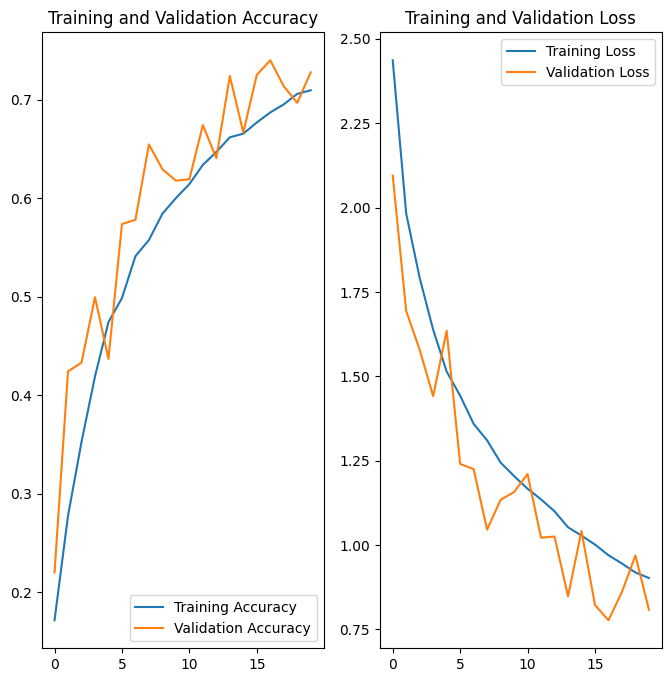

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
import os
from collections import Counter

def generate_label_name_mapping(dataset, class_names):
    """
    Generate a dictionary mapping numeric labels to class names.

    Args:
    - dataset: A TensorFlow dataset where labels are numeric.
    - class_names: List of class names in the same order as used for dataset creation.

    Returns:
    - Dictionary mapping numeric labels to class names.
    """
    label_counts = Counter()

    # Collect numeric labels from the dataset
    for _, labels in dataset:
        labels = labels.numpy()  # Convert TensorFlow tensor to numpy array
        label_counts.update(labels)

    # Generate the label-to-name mapping
    label_name_mapping = {label: class_names[label] for label in sorted(label_counts.keys())}
    return label_name_mapping

# Example usage
# Assuming `class_names` is extracted from the dataset directory structure
class_names =validation_dataset.class_names # Ensure classes are sorted consistently
label_name_mapping = generate_label_name_mapping(validation_dataset, class_names)

# Print the mapping
print("Label-to-Class Name Mapping:")
for label, name in label_name_mapping.items():
    print(f"{label}: {name}")

Label-to-Class Name Mapping:
0: Bicycle
1: Bridge
2: Bus
3: Car
4: Crosswalk
5: Hydrant
6: Other
7: Palm
8: Traffic Light


2024-12-09 15:07:45.747418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


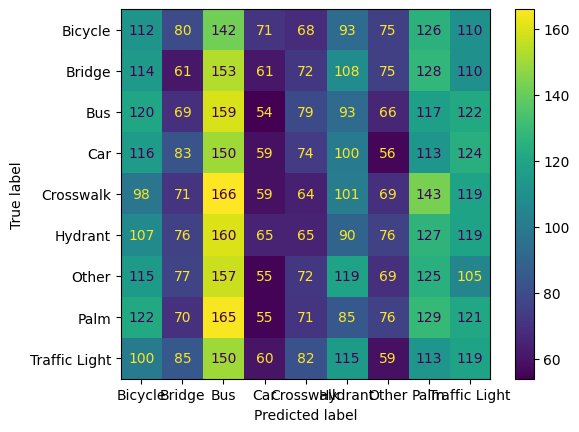

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(validation_dataset)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())

classes = validation_dataset.class_names

# Générer une matrice de confusion
cm = confusion_matrix(y_true, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

In [47]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # Convert the labels from tensor to numpy

# Step 2: Get predictions from the model (do this once, not twice)
predictions = model.predict(validation_dataset)

# Convert predictions to class labels (assuming probabilities)
predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability for each sample

# Step 3: Generate the classification report
report = classification_report(y_true, predicted_labels,  output_dict=True)
report_print = classification_report(y_true, predicted_labels)

print(report_print)

class_f1_scores = {f"Class {k} F1": v['f1-score'] for k, v in report.items() if k.isdigit()}

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

           0       0.10      0.11      0.10       877
           1       0.10      0.08      0.09       882
           2       0.12      0.19      0.15       879
           3       0.12      0.07      0.09       875
           4       0.11      0.08      0.09       890
           5       0.10      0.10      0.10       885
           6       0.11      0.08      0.09       894
           7       0.12      0.16      0.14       894
           8       0.12      0.14      0.13       883

    accuracy                           0.11      7959
   macro avg       0.11      0.11      0.11      7959
weighted avg       0.11      0.11      0.11      7959



In [62]:
import csv

def save_class_f1_scores_to_csv(class_f1_scores, file_name):
    """
    Saves a dictionary of class F1 scores to a CSV file.
    """
    with open(file_name, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(["Class", "F1 Score"])
        # Write each key-value pair as a row
        for class_name, f1_score in class_f1_scores.items():
            writer.writerow([class_name, f1_score])
    
    print(f"Class F1 scores saved to {file_name}")

In [64]:
import os
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory

In [63]:
file_name_csv = "model_"+str(nb)+"_f1_scores.csv" #"results1/f1_scores/model_"+str(nb)+"_f1_scores.csv"

save_class_f1_scores_to_csv(class_f1_scores, file_name_csv)

FileNotFoundError: [Errno 2] No such file or directory: 'model_2_4_1_f1_scores.csv'

In [42]:
loss, accuracy = model.evaluate(test_dataset, batch_size=BATCH_SIZE)

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7173 - loss: 0.8314


In [43]:
import csv
import os

def add_to_csv(file_name, row):
    """
    Adds a row to a CSV file. If the file does not exist, it creates the file with the header.

    :param file_name: Name of the CSV file.
    :param header: List containing column names.
    :param row: List containing a single row of data to add.
    """
    file_exists = os.path.exists(file_name)
    header = ["Model", "Accuracy", "loss", "f1 score file", "Epochs", "Batch Size", "Optimizer", "learning rate"]

    with open(file_name, mode="a", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write header if the file does not exist
        if not file_exists:
            writer.writerow(header)

        # Write the row
        writer.writerow(row)

In [44]:
row = ["model "+ str(nb), accuracy, loss, file_name_csv , EPOCHS , BATCH_SIZE, "Adam", LR_Rate]
add_to_csv("./results/global/recap_models.csv", row)

#### Results     
In this part we managed to go from a model able to distinguish one class only, to detect the 9 different classes left by the data processing. 
As we see our models trains well, and reach an accuracy of 0.70 at most. 
model_2 model_2_3_1

<div style="display: flex; align-items: center;">
  <img src="./results/graphs/&quot;model_2&quot;.png" alt="Model 2 Graph" style="margin-right: 10px; width: 300px;">
  <p>For this model we have a fine accuracy around 0.7, however when looking at the file about the f1-scores per class (results/f1_scores/model_2_f1_scores.csv), we see that our model do not really differenciate well our classes.  </p>
</div>

To resolve this we made updates on teh preprocessing, and tried to increase the model's complexity, to try to grasp more differents patterns linked to the different classes. First we tried to increment the number of filters in each convolution layer. 

<div style="display: flex; align-items: center;">
  <img src="./results/graphs/&quot;model_2_2_6&quot;.png" alt="Model 2 Graph" style="margin-right: 10px; width: 300px;">
  <p>For this model we have a fine accuracy around 0.59, however when looking at the file about the f1-scores per class (results/f1_scores/model_2_2_6_f1_scores.csv), we see that our model is still unable to differenciate well our classes.  </p>
</div>



Also we tried to add the batch normalization layer and one more convolution layer to see if it was moere efficient. 

<div style="display: flex; align-items: center;">
  <img src="./results/graphs/&quot;model_2_3_1&quot;.png" alt="Model 2 Graph" style="margin-right: 10px; width: 300px;">
  <p>For this model we have a fine accuracy around 0.70, however when looking at the file about the f1-scores per class (results/f1_scores/model_2_3_1_f1_scores.csv), we see that this model too is still unable to differenciate well our classes.  </p>
</div>


Finaly we add more convolution layer to see if it was more efficient. 

<div style="display: flex; align-items: center;">
  <img src="./results/graphs/&quot;model_2_4_1&quot;.png" alt="Model 2 Graph" style="margin-right: 10px; width: 300px;">
  <img src="./results/graphs/&quot;confu_matrix_2_4_1&quot;.png" alt="Model 2 Graph" style="margin-right: 10px; width: 300px;">
  <p>For this model we have a fine accuracy around 0.70, however when looking at the file about the f1-scores per class (results/f1_scores/model_2_4_1_f1_scores.csv), we see that this model too is still unable to differenciate well our classes.  </p>
</div>

#### 2 partie augustin

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



# > 0.74 Val accuracy, 0.80 removing Others
second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "Second_Model")

'''# > 0.75 Val accuracy
second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "Second_Model")

second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(len(CLASS_NAMES), activation='softmax')
])



second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),  
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "Second_Model")'''

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

second_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

second_model.summary()

In [ ]:
EPOCHS_SECOND = 20
second_history = second_model.fit(
  train_dataset,
  validation_data= validation_dataset,
  epochs=EPOCHS_SECOND
)

In [ ]:
acc = second_history.history['accuracy']
val_acc = second_history.history['val_accuracy']

loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs_range = range(EPOCHS_SECOND)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # Convert the labels from tensor to numpy

# Step 2: Get predictions from the model (do this once, not twice)
predictions = second_model.predict(validation_dataset)

# Convert predictions to class labels (assuming probabilities)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Generate the classification report
infos_2 = classification_report(y_true, predicted_labels)
print(infos_2)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = first_model.predict(validation_dataset)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())

#LABELS = {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant':6, 'Motorcycle':7, 'Other':8, 'Palm':9, 'Stair':10, 'Traffic Light':11}
#classes = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']

LABELS = {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Crosswalk': 4, 'Hydrant':5, 'Palm':7, 'Traffic Light':8}
classes = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Crosswalk', 'Hydrant', 'Palm', 'Traffic Light']

report = classification_report(y_true, y_pred_class, target_names=classes)
print("Classification Report:")
print(report)

# Générer une matrice de confusion
cm = confusion_matrix(y_true, y_pred_class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, decimals=2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                              display_labels=classes)
disp.plot()

In [ ]:
import tensorflow as tf
import numpy as np

good_pred = 0
bad_pred = 0

for i in range(1,1000):
    
    img_path = getImagesDataFolderPath() +"/Bicycle/Bicycle ("+ str(i) +").png"

    #load image
    try:

        img = tf.keras.utils.load_img(
            img_path, target_size=(IMG_DIMENSIONS[0], IMG_DIMENSIONS[1])
        )

        # image to array
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch


        #make prediction
        predictions = second_model.predict(img_array)
        #get score
        score = tf.nn.softmax(predictions[0])

        if CLASS_NAMES[np.argmax(score)] == "Bicycle":
            good_pred += 1
        else:
            bad_pred += 1

    except:
        pass
    
    #print("This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score)))

print(good_pred)
print(bad_pred)
print(good_pred/(good_pred+bad_pred))

In [ ]:
import tensorflow as tf
import numpy as np

img_path = getImagesDataFolderPath() +"/Bicycle/Bicycle (778).png"
#img_path = getImagesDataFolderPath() +"/Bridge/Bridge (112).png"
#img_path = getImagesDataFolderPath() +"/Chimney/Chimney (28).png"
#img_path = getImagesDataFolderPath() +"/Other/Other (903).png"
#img_path = getImagesDataFolderPath() +"/Stair/Stair (1560).png"
#img_path = getImagesDataFolderPath() +"/Car/Car (72).png"

#load image
img = tf.keras.utils.load_img(
    img_path, target_size=(IMG_DIMENSIONS[0], IMG_DIMENSIONS[1])
)

# image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


#make prediction
predictions = second_model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score)))

Bicycle:        709     70      0.91
Bus:            37      1171    0.03
Bridge:         4       528     0.007
Car:            35      496     0.066
Crosswalk:      37      962     0.037
Hydrant:        5       947     0.005
Palm:           6       905     0.007
Traffic Light:  13      778     0.016

### 3 Testing with Resnet layers

##### resnet50 
Premier resnet, nécessite une fonction de preprocessing pour adapter les images en entrées pour être adapté aux images sur lequel resnet a été entrainé.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

first_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  ResNet101V2(include_top=False, input_shape=(120,120,3)),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "First_Model")

callback = EarlyStopping(patience=2)

first_model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

first_model.summary()

##### resnet101 
Légèrement plus efficace mais plus long

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

first_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  ResNet50V2(include_top=False, input_shape=(120,120,3)),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "First_Model")

callback = EarlyStopping(patience=2)

first_model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

first_model.summary()

from tensorflow.image import decode_jpeg, resize

from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_DIMENSIONS = (120, 120) # pixels per pixels
SEED_RANDOM = 123

VALIDATION_RATIO = 0.2

def getDatasets(batch_size=BATCH_SIZE,
                img_dims=IMG_DIMENSIONS,
                validation_ratio=VALIDATION_RATIO,
                seed=SEED_RANDOM) -> tuple:
  train = image_dataset_from_directory(
    getImagesDataFolderPath(),
    validation_split= validation_ratio,
    subset= "training",

    seed=       seed,
    image_size= img_dims,
    batch_size= batch_size)

  validation = image_dataset_from_directory(
    getImagesDataFolderPath(),
    validation_split= validation_ratio,
    subset= "validation",

    seed=       seed,
    image_size= img_dims,
    batch_size= batch_size)

  return train, validation




train_dataset, validation_dataset = getDatasets()

train_dataset= train_dataset.map(preprocess_data_for_resnet).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.map(preprocess_data_for_resnet).cache().prefetch(buffer_size=AUTOTUNE)
EPOCHS_FIRST= 15

first_history = first_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS_FIRST
)

##### Essai Early stopping
L'entrainement étant assez instable il est difficile d'utiliser la fonctionalité early stopping. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

train_dataset, validation_dataset = getDatasets()

train_dataset= train_dataset.map(preprocess_data_for_resnet).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.map(preprocess_data_for_resnet).cache().prefetch(buffer_size=AUTOTUNE)
EPOCHS_FIRST= 15

first_history = first_model.fit(
  train_dataset,
  callbacks=[callback],
  validation_data=validation_dataset,
  epochs=EPOCHS_FIRST
)